Imports and data load

# 🔍 SSH Log Analysis Tutorial (Python + Jupyter Notebook)

This notebook demonstrates how to perform simple log analysis in Python using **pandas**, **regular expressions**, and **matplotlib**.

We’ll:
1. Load and parse a Linux-style `auth.log` file.
2. Extract fields such as timestamp, hostname, and source IP.
3. Identify failed SSH login attempts.
4. Analyze attack patterns (top source IPs, per-host counts, time trends).
5. Visualize the results using bar and line charts.

---


%pip install pandas matplotlib


In [ ]:
%pip install pandas matplotlib


## 🧩 Step 1: Load the Log File

We'll start by reading the contents of `auth.log` into memory.  
Each line in this file typically represents one system authentication event (e.g., login success, failure, sudo use).



In [1]:
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Path to your uploaded auth.log
LOG_PATH = "auth.log"

with open(LOG_PATH, "r", encoding="utf-8") as f:
    lines = f.readlines()

print(f"Loaded {len(lines)} log lines.")


Loaded 55 log lines.


2. Parse log lines

The following regex matches SSH failed login attempts:

Cell 2 — Extract fields

## 🧠 Step 2: Parse SSH Log Entries

We'll use a **regular expression (regex)** to match the relevant lines — in this case, failed SSH login attempts that look like:

Sep 4 01:12:08 web01 sshd[14321]: Failed password for root from 203.0.113.5 port 53211 ssh2


## 🧩 Understanding the Regular Expression (Regex)

To extract data from each SSH log line, we used the following regex pattern:

```python
r"^(?P<month>\w{3})\s+(?P<day>\d{1,2})\s+(?P<time>\d{2}:\d{2}:\d{2})\s+(?P<host>\S+)\s+sshd\[\d+\]:\s+Failed password.*?from\s+(?P<ip>[0-9.]+)"


| **Part**                      | **Meaning**                                                                                  | **Example Match**        |
| ----------------------------- | -------------------------------------------------------------------------------------------- | ------------------------ |
| `^`                           | Anchors the match to the **start of the line**                                               | (beginning of log entry) |
| `(?P<month>\w{3})`            | Captures the **3-letter month abbreviation** as a named group `month`                        | `Sep`                    |
| `\s+`                         | Matches one or more spaces                                                                   | `"  "`                   |
| `(?P<day>\d{1,2})`            | Captures the **day of the month** (1–2 digits) as `day`                                      | `4`                      |
| `\s+`                         | One or more spaces                                                                           | `"  "`                   |
| `(?P<time>\d{2}:\d{2}:\d{2})` | Captures the **time** in `HH:MM:SS` format as `time`                                         | `01:12:08`               |
| `\s+`                         | Space(s) between time and hostname                                                           |                          |
| `(?P<host>\S+)`               | Captures the **hostname** (non-space characters) as `host`                                   | `web01`                  |
| `\s+sshd\[\d+\]:\s+`          | Matches literal text like `sshd[14321]:` — the SSH daemon process ID in brackets             | `sshd[14321]:`           |
| `Failed password`             | Matches the literal phrase `Failed password`                                                 | `Failed password`        |
| `.*?`                         | Matches any characters (non-greedy) — allows for optional text like “for invalid user admin” |                          |
| `from\s+`                     | Matches the literal text `"from"` followed by spaces                                         | `from `                  |
| `(?P<ip>[0-9.]+)`             | Captures the **IPv4 address** as `ip`                                                        | `203.0.113.5`            |


In [26]:
# Regex for failed password lines
pattern = re.compile(
    r"^(?P<month>\w{3})\s+(?P<day>\d{1,2})\s+(?P<time>\d{2}:\d{2}:\d{2})\s+(?P<host>\S+)\s+sshd\[\d+\]:\s+Failed password.*?from\s+(?P<ip>[0-9.]+)"
)

records = []
for line in lines:
    m = pattern.search(line)
    if m:
        data = m.groupdict()
        timestamp = f"{data['month']} {data['day']} {data['time']}"
        records.append({
            "timestamp": timestamp,
            "host": data["host"],
            "ip": data["ip"],
        })

df = pd.DataFrame(records)
print(df.head())
print(f"\nParsed {len(df)} failed login lines.")


        timestamp   host           ip
0  Sep 4 01:12:08  web01  203.0.113.5
1  Sep 4 01:12:10  web01  203.0.113.5
2  Sep 4 01:12:12  web01  203.0.113.5
3  Sep 4 01:12:15  web01  203.0.113.5
4  Sep 4 01:12:17  web01  203.0.113.5

Parsed 21 failed login lines.


3. Simple analysis
Cell 3 — Top source IPs

## 📊 Step 3: Analyze Top Source IPs

Now that we have a clean dataframe of failed logins,  
let’s find which IP addresses generated the most failed attempts.

This helps identify brute-force attackers or noisy scanning sources.


Top 5 attacking IPs:
ip
203.0.113.5      15
198.51.100.23     3
192.0.2.44        3
Name: count, dtype: int64


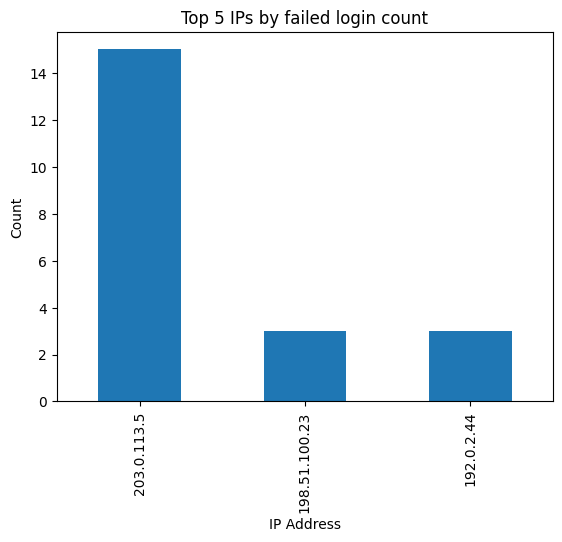

In [27]:
top_ips = df["ip"].value_counts().head(5)
print("Top 5 attacking IPs:")
print(top_ips)
top_ips.plot(kind="bar", title="Top 5 IPs by failed login count")
plt.xlabel("IP Address")
plt.ylabel("Count")
plt.show()


Cell 4 — Failed logins per host

## 🖥️ Step 4: Failed Logins per Host

We can also check which servers received the most failed login attempts.  
This may highlight exposed or misconfigured hosts.


host
web01    21
Name: count, dtype: int64


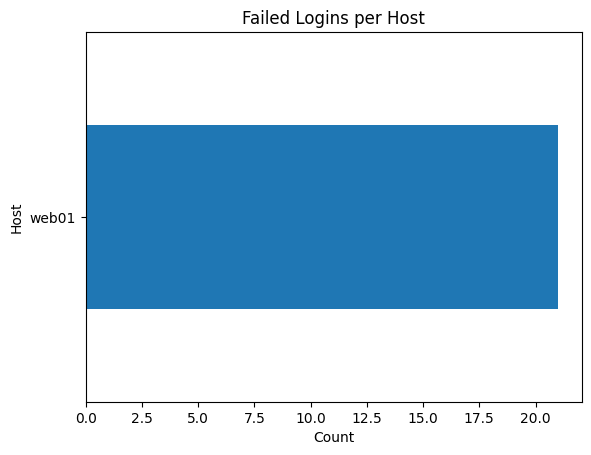

In [28]:
failures_by_host = df["host"].value_counts()
print(failures_by_host)

failures_by_host.plot(kind="barh", title="Failed Logins per Host")
plt.xlabel("Count")
plt.ylabel("Host")
plt.show()


4. Optional — Convert timestamps

## ⏱️ Step 5: Trend of Failed Logins Over Time

Let's convert the string timestamps into real Python `datetime` objects  
so we can plot how failed logins occur throughout the day or over multiple days.


In [ ]:
# Convert timestamp strings to datetime objects
df["datetime"] = pd.to_datetime(df["timestamp"] + " 2025", format="%b %d %H:%M:%S %Y", errors="coerce")
df = df.dropna(subset=["datetime"])

# Plot activity over time
df.set_index("datetime").resample("H").size().plot(title="Failed Logins Over Time", figsize=(10,4))
plt.xlabel("Hour")
plt.ylabel("Failed login count")
plt.show()


## 🚀 Step 6: Possible Extensions

You can expand this notebook by:
- Counting **unique usernames** attempted per IP.
- Detecting **brute-force bursts** (e.g., >5 attempts in 5 minutes).
- Joining with an **asset inventory** CSV to identify critical systems.
- Exporting alerts to a **SIEM** or dashboard (e.g., Elastic, Splunk, Grafana).

---

